In [1]:
# Import necessary modules

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2

In [2]:
# Load the images directories
path = "D:/brain_tumor_dataset"
print(os.listdir(path))

image_paths = list(paths.list_images(path))
print(len(image_paths))

['no', 'yes']
253


In [3]:
# 
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

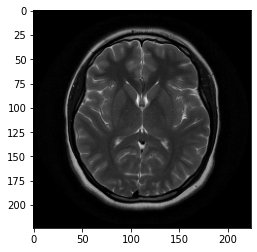

In [4]:
# Plot an image
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

In [5]:
# Convert into numpy arrays
images = np.array(images) / 255.0
labels = np.array(labels)

In [6]:
# Perform One-hot encoding
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)
print(labels[0])

[1. 0.]


In [7]:
#Split the dataset
(train_X, test_X, train_Y, test_Y) = train_test_split(images, 
                                                      labels, 
                                                      test_size= 0.10,
                                                      random_state= 42, stratify= labels)

In [8]:
# Build the Image Data Generator
train_generator = ImageDataGenerator(fill_mode= 'nearest', 
                                     rotation_range= 15)

In [9]:
# Build the model
base_model = VGG16(weights= 'imagenet', 
                   input_tensor= Input(shape = (224, 224, 3)), 
                   include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

58892288/58889256 [==============================] - 35s 1us/step


In [10]:
# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

In [11]:
# Compile the model
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), 
              metrics= ['accuracy'], loss= 'binary_crossentropy')

In [12]:
# Let's see the architecture summary of our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

In [14]:
# Fit the model
history = model.fit_generator(train_generator.flow(train_X, 
                                                   train_Y, 
                                                   batch_size = batch_size),
                              steps_per_epoch= train_steps,
                              validation_data = (test_X, test_Y),
                              validation_steps= validation_steps,
                              epochs= epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
28/28 [==============================] - 82s 3s/step - loss: 0.6881 - accuracy: 0.6164 - val_loss: 0.6093 - val_accuracy: 0.6154
Epoch 2/10
28/28 [==============================] - 74s 3s/step - loss: 0.6869 - accuracy: 0.5845 - val_loss: 0.5695 - val_accuracy: 0.6154
Epoch 3/10
28/28 [==============================] - 81s 3s/step - loss: 0.6073 - accuracy: 0.6804 - val_loss: 0.5344 - val_accuracy: 0.8462
Epoch 4/10
28/28 [==============================] - 78s 3s/step - loss: 0.6101 - accuracy: 0.6530 - val_loss: 0.4963 - val_accuracy: 0.9231
Epoch 5/10
28/28 [==============================] - 76s 3s/step - loss: 0.5888 - accuracy: 0.6758 - val_loss: 0.4408 - val_accuracy: 0.9231
Epoch 6/10
28/28 [==============================] - 79s 3s/step - loss: 0.5536 - accuracy: 0.7671 - val_loss: 0.4115 - val_accuracy: 0.9231
Epoch 7/10
28/28 [==============================] - 77s 3s/step - loss: 0.5209 - acc

In [15]:
# Evaluate the model
predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

In [16]:
# Print Classification report and Confusion matrix
print(classification_report(actuals, predictions, 
                            target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

              precision    recall  f1-score   support

          no       0.91      1.00      0.95        10
         yes       1.00      0.94      0.97        16

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26

[[10  0]
 [ 1 15]]


In [17]:
# Final accuracy of our model
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9615


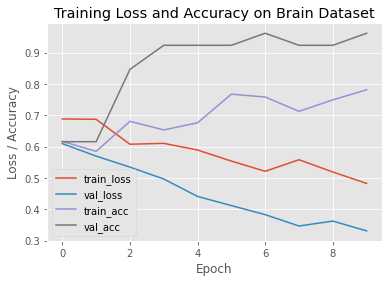

In [18]:
# Plot the losses and accuracies
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], 
         label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], 
         label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], 
         label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], 
         label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")